## **Dataset and Problem Description**

The dataset used in this project is the **MBA Admission Dataset, Class of 2025**, which is a classification problem. The dataset contains several instances with 9 features, and the target variable is **admission status** (Admit, Waitlist, or Deny). The dataset is relatively balanced but may contain bias due to factors such as gender, race, and academic background, which can affect the fairness of the admissions process.

The dataset is available at https://www.kaggle.com/datasets/taweilo/mba-admission-dataset

### **Features**
This dataset includes various attributes of the applicants, such as:

- **application_id**: Unique identifier for each application
- **gender**: Applicant's gender (Male, Female)
- **international**: Whether the applicant is an international student (TRUE/FALSE)
- **gpa**: Grade Point Average (on a 4.0 scale)
- **major**: Undergraduate major (Business, STEM, Humanities)
- **race**: Racial background of the applicant (e.g., White, Black, Asian, Hispanic, Other / null: international student)
- **gmat**: GMAT score (out of 800)
- **work_exp**: Number of years of work experience
- **work_industry**: Industry of previous work experience (e.g., Consulting, Finance, Technology, etc.)
- **admission**: Admission status (Admit, Waitlist, Deny)

### **Why this dataset?**

The **MBA Admission Dataset** and the **Rotterdam system** both share concerns regarding **fairness** and **explainability**, but in different contexts. While the Rotterdam system is punitive, as it denies essential benefits, the MBA admission process is not punitive, though it still has a significant impact on candidates' future professional opportunities. Both systems, however, can be affected by biases such as **gender**, **ethnicity**, and other demographic factors, which may influence the decision-making process in unjust ways.

Just as the Rotterdam system faced criticism for lack of fairness and transparency in its decisions, the MBA admissions process also raises similar concerns. Factors like **gender**, **race**, **academic performance**, and **work experience** can inadvertently introduce bias, potentially leading to unfair outcomes for certain groups. Therefore, **explainability** is crucial in both cases. For the MBA admission process, it is essential to ensure that the decisions are transparent and that the criteria used are well-understood by all stakeholders. This way, we can ensure that admissions are based on merit, not influenced by bias, and that the process is just, transparent, and accountable.

In both cases, addressing fairness and improving explainability will lead to better decision-making, ensuring that individuals are not unfairly excluded or advantaged based on arbitrary or discriminatory factors.

## **Prerequisites**

To run this notebook, you need to have the following libraries installed:
- `pandas`
- `matplotlib`
- `seaborn`
- `scikit-learn`
- `imbalanced-learn`
- `shap`
- `lime`

You can install the required libraries using `pip` as shown below:


In [41]:
%pip install -qU pandas matplotlib seaborn scikit-learn imbalanced-learn shap lime

Note: you may need to restart the kernel to use updated packages.


In [42]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import partial_dependence, PartialDependenceDisplay
from sklearn.inspection import permutation_importance
import shap
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


shap.initjs()

df = pd.read_csv("MBA.csv")
df.head()

,application_id,gender,international,gpa,major,race,gmat,work_exp,work_industry,admission
0,1,Female,False,3.30,Business,Asian,620.0,3.0,Financial Services,Admit
1,2,Male,False,3.28,Humanities,Black,680.0,5.0,Investment Management,NaN
2,3,Female,True,3.30,Business,NaN,710.0,5.0,Technology,Admit
3,4,Male,False,3.47,STEM,Black,690.0,6.0,Technology,NaN
4,5,Male,False,3.35,STEM,Hispanic,590.0,5.0,Consulting,NaN


### **Feature Engineering and Preprocessing**


In [43]:
df['gender'].unique()

array(['Female', 'Male'], dtype=object)

#### **Remove Unnecessary Columns**
We will remove the `application_id` column, as it serves as a unique identifier and does not contribute meaningful information for the model's predictions.


In [44]:
del(df['application_id'])

#### **Fill Missing Values**

The dataset's target variable, `admission`, contains missing values, which are interpreted as cases of no admission. We will replace these missing values with the string `No admit` to indicate that the applicant was not admitted.

In [45]:
df.admission = df.admission.fillna('No admit')
df.head()

,gender,international,gpa,major,race,gmat,work_exp,work_industry,admission
0,Female,False,3.30,Business,Asian,620.0,3.0,Financial Services,Admit
1,Male,False,3.28,Humanities,Black,680.0,5.0,Investment Management,No admit
2,Female,True,3.30,Business,NaN,710.0,5.0,Technology,Admit
3,Male,False,3.47,STEM,Black,690.0,6.0,Technology,No admit
4,Male,False,3.35,STEM,Hispanic,590.0,5.0,Consulting,No admit


We observed that the `race` feature has missing values when the `international` feature is set to `TRUE`, indicating that the applicant is an international student. To address this, we will replace the missing values in the `race` feature with the string `International`. Additionally, we will remove the `international` feature, as it is no longer relevant for the model.

In [46]:
df[df.international]["race"].unique()

array([nan], dtype=object)

In [47]:
df.race = df.race.fillna('International')
del(df['international'])

Now, we treated all missing values in the dataset.

In [48]:
df.isnull().sum().sum()

0

#### **Encoding Categorical Features**

We will encode the categorical features using mapping dictionaries and LabelEncoder from scikit-learn. The categorical features include `gender`, `major`, `race`, `work_industry`, and the target variable `admission`.

We created `X_display` and `y_display` to preserve the original, unmodified data for analysis, even after label encoding is applied. Once we encode the features and target variable, we will use the encoded versions in `X` and `y` for modeling. The goal of keeping `X_display` and `y_display` is to retain access to the raw data for visualization and comparison before applying any transformations.

In [49]:
X_display = df.drop('admission', axis=1)
y_display = df['admission']

Mapping the column `admission` to integers:

In [50]:
admission_mapping = {'Admit': 1, 'Waitlist': 0, 'No admit': 0}
df['admission'] = df.admission.map(admission_mapping)

Here we calculate the average admission rate for each racial group in the dataset. By grouping the data based on the `race` feature and then calculating the mean of the `admission` variable, it shows the proportion of admissions (e.g., the percentage of admitted students) for each race. This can help identify any patterns or disparities in admissions across different racial groups.


In [51]:
df.groupby("race")["admission"].mean()

race
Asian            0.165650
Black            0.087336
Hispanic         0.104027
International    0.150923
Other            0.194093
White            0.167582
Name: admission, dtype: float64

We will convert the `gender` column to a binary format and use `LabelEncoder` to encode the categorical columns `major`, `race`, and `work_industry`.

In [52]:
df.gender = (df.gender == 'Female').astype(int)

for col in df.select_dtypes(include=['object']).columns: # major race and work_industry
    df[col] = LabelEncoder().fit_transform(df[col])


In [53]:
df.head()

,gender,gpa,major,race,gmat,work_exp,work_industry,admission
0,1,3.30,0,0,620.0,3.0,3,1
1,0,3.28,1,1,680.0,5.0,6,0
2,1,3.30,0,3,710.0,5.0,13,1
3,0,3.47,2,1,690.0,6.0,13,0
4,0,3.35,2,2,590.0,5.0,1,0


Here we will visualize the correlation matrix of the dataset to understand the relationships between different features. This can help identify any patterns or dependencies between the features.

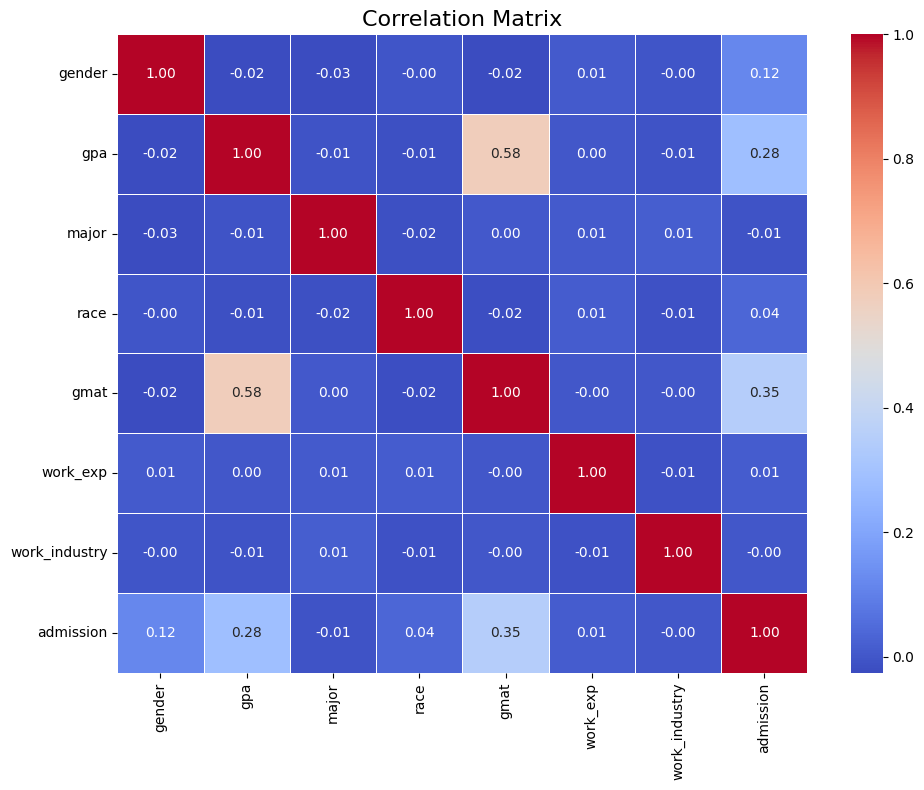

In [54]:
corr_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix', fontsize=16)
plt.tight_layout()
plt.show()

Now, we will analyze the correlation between the features and the target variable `admission` to understand how each feature is related to the target.

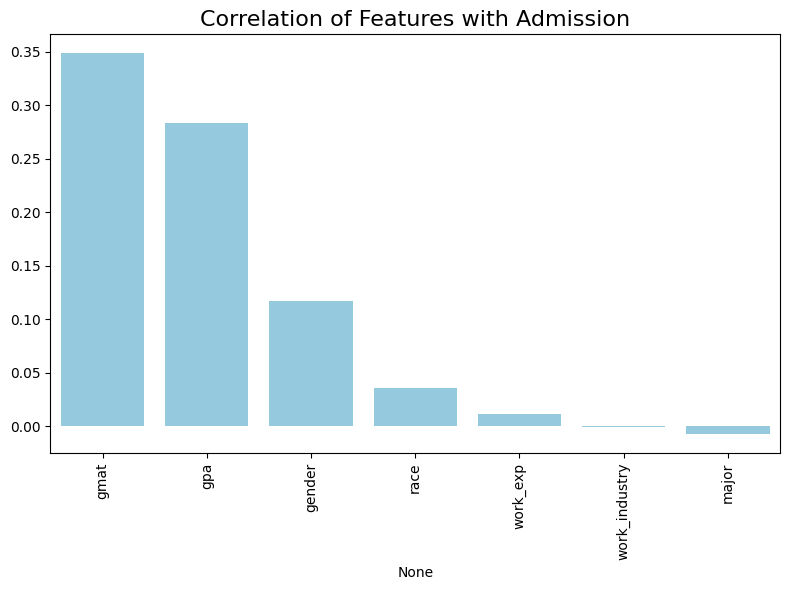

In [55]:
corr_with_admission = corr_matrix['admission'].sort_values(ascending=False)
corr_with_admission = corr_with_admission.drop('admission')

plt.figure(figsize=(8, 6))
sns.barplot(x=corr_with_admission.index, y=corr_with_admission.values, color='skyblue')
plt.xticks(rotation=90)
plt.title('Correlation of Features with Admission', fontsize=16)
plt.tight_layout()
plt.show()

### **Modeling**

Now that we have preprocessed the data, we can proceed with building a machine learning model to predict the admission status based on the applicant's features. For this, we will use the **Gradient Boosting Machine (GBM)** model, the same algorithm used in the Rotterdam case, to ensure robust predictions. The following steps outline the process we'll follow:

#### **Splitting the Data**
We will split the data into training and testing sets using a 80-20 split. This will allow us to train the model on a subset of the data and evaluate its performance on unseen data.


In [56]:
X = df.drop('admission', axis=1)
y = df['admission']

#### **Using BL-SMOTE**

We will apply the **``Borderline-SMOTE (BL-SMOTE)``** technique to address class imbalance in the dataset. ``BL-SMOTE`` is an extension of the **``Synthetic Minority Over-sampling Technique (SMOTE)``** that specifically targets borderline instances, which are minority class samples near the decision boundary or surrounded by majority class samples. These instances are at higher risk of misclassification. By oversampling these borderline instances, BL-SMOTE enhances the representation of the minority class in challenging regions, improving the model's ability to correctly classify these cases while minimizing the risk of overfitting.


In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

borderlinesmote = BorderlineSMOTE(random_state=42)
X_res, y_res = borderlinesmote.fit_resample(X_train, y_train)

We can now plot the difference between the original and the sampled data (using t-SNE):

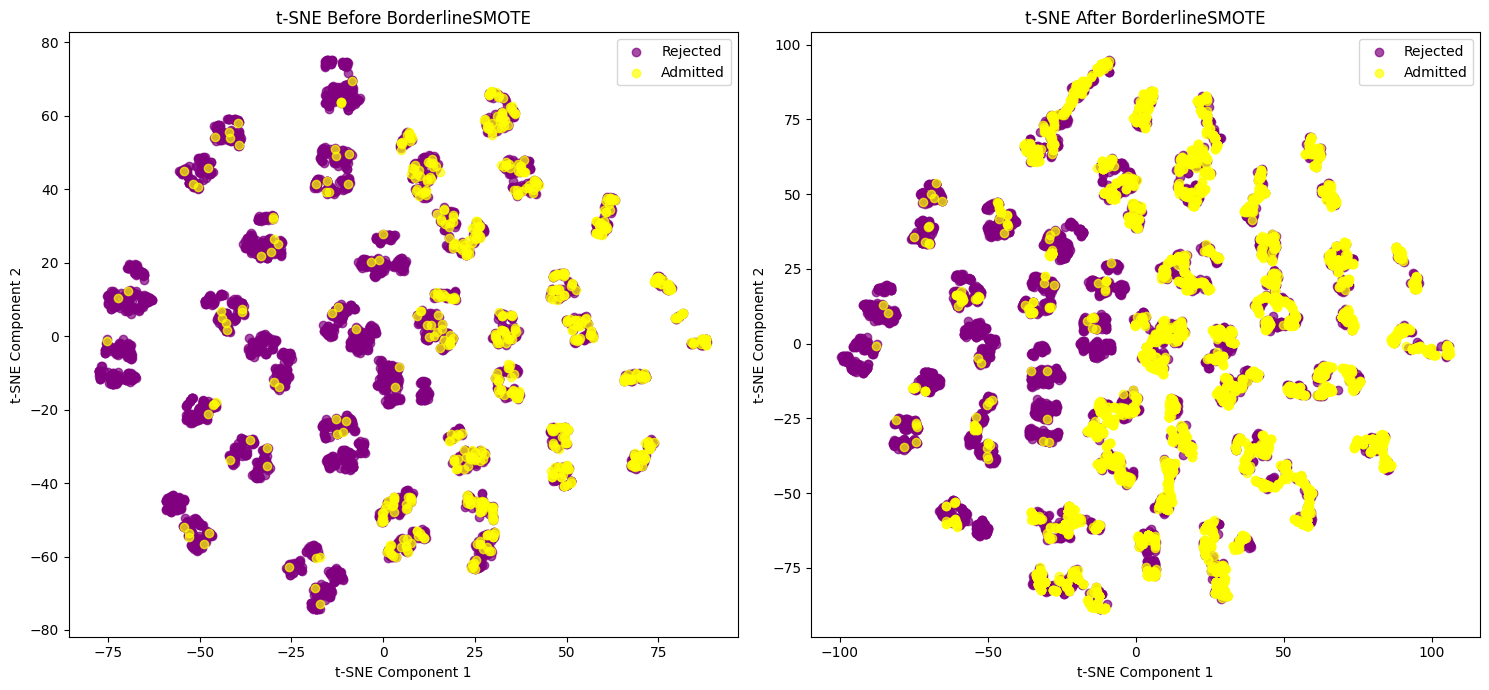

In [58]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.manifold import TSNE

colors = {0: 'purple', 1: 'yellow'}  # Assuming 0 = Rejected, 1 = Admitted

tsne_before = TSNE(n_components=2, random_state=42)
X_train_tsne = tsne_before.fit_transform(X_train)

tsne_after = TSNE(n_components=2, random_state=42)
X_res_tsne = tsne_after.fit_transform(X_res)

fig, axes = plt.subplots(1, 2, figsize=(15, 7))

for label, color in colors.items():
    mask = y_train == label
    axes[0].scatter(
        X_train_tsne[mask, 0],
        X_train_tsne[mask, 1],
        c=color,
        label="Admitted" if label == 1 else "Rejected",
        alpha=0.7
    )
axes[0].set_title('t-SNE Before BorderlineSMOTE')
axes[0].set_xlabel('t-SNE Component 1')
axes[0].set_ylabel('t-SNE Component 2')
axes[0].legend()

for label, color in colors.items():
    mask = y_res == label
    axes[1].scatter(
        X_res_tsne[mask, 0],
        X_res_tsne[mask, 1],
        c=color,
        label="Admitted" if label == 1 else "Rejected",
        alpha=0.7
    )
axes[1].set_title('t-SNE After BorderlineSMOTE')
axes[1].set_xlabel('t-SNE Component 1')
axes[1].set_ylabel('t-SNE Component 2')
axes[1].legend()

plt.tight_layout()
plt.show()


Now, we will train the **Gradient Boosting Machine (GBM)** model on the training data. The model will learn the relationships between the applicant's features and their admission status.



In [59]:
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbc.fit(X_res, y_res)

GradientBoostingClassifier(random_state=42)

#### **Model Evaluation**

The classification report evaluates the model's ability to predict MBA admission, where `0` represents "not admitted" and `1` represents "admitted."

#### **Class 0 (Not Admitted)**
- **Precision (0.92):** The model accurately identifies most candidates who should not be admitted.
- **Recall (0.81):** It correctly detects 81% of actual "not admitted" cases.
- **F1-score (0.86):** Indicates strong overall performance for this class.

#### **Class 1 (Admitted)**
- **Precision (0.38):** Only 38% of predicted "admitted" cases are correct, indicating many false positives.
- **Recall (0.61):** The model captures 61% of actual "admitted" cases but misses some true positives.
- **F1-score (0.47):** Highlights weaker performance for this class.

#### **Overall Metrics**
- **Accuracy (0.78):** 78% of instances are correctly classified, though this favors the majority class.
- **Macro Avg (F1-score 0.67):** Reflects weaker performance on class 1.
- **Weighted Avg (F1-score 0.80):** Skewed by the dominance of class 0.

### **Conclusion**

Since we used the **`BL-SMOTE`** technique to address class imbalance, we saw some improvement in the model's performance, particularly in terms of recall for the minority class. However, the precision for the minority class remains low, indicating a high rate of false positives. This suggests that the model may be incorrectly classifying some applicants as admitted when they should not be.


In [60]:
y_pred = gbc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.81      0.86      1043
           1       0.38      0.61      0.47       196

    accuracy                           0.78      1239
   macro avg       0.65      0.71      0.67      1239
weighted avg       0.83      0.78      0.80      1239



### **Explainability and Feature Importance**

To enhance **explainability**, we will extract the feature importances from the trained model, which tells us how much each feature contributes to the model's predictions. By plotting a bar chart of these feature importances, we can visualize which features have the most influence on predicting admission, such as GMAT score, GPA, or work experience. This step helps provide transparency into the model's decision-making process, allowing us to better understand and explain why certain predictions are made.

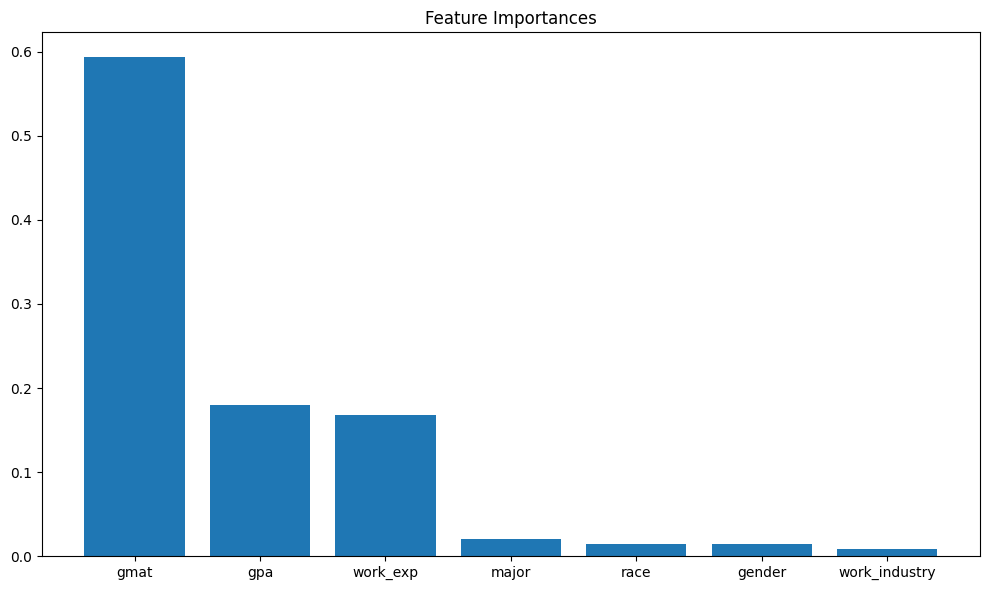

In [61]:
importances = gbc.feature_importances_

# Plot feature importances
feature_importance = sorted(zip(importances, X_train.columns), reverse=True)

plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), [imp for imp, _ in feature_importance])
plt.xticks(range(len(importances)), [name for _, name in feature_importance])
plt.title("Feature Importances")
plt.tight_layout()
plt.show()

#### **Permutation importance**
This measure is calculated for each feature by randomly shuffling its values and evaluating the difference in the model's performance. The higher the importance score, the more influential the feature is by itself in the model's predictions.

GMAT and GPA have some correlation which means that shuffling one of them is not as effective in degrading the model's performance.

Negative scores mean that the model was better at predicting the outcomes with the randomly shuffled feature values, which can mean that the model is overfitted and/or that the feature is irrelevant.

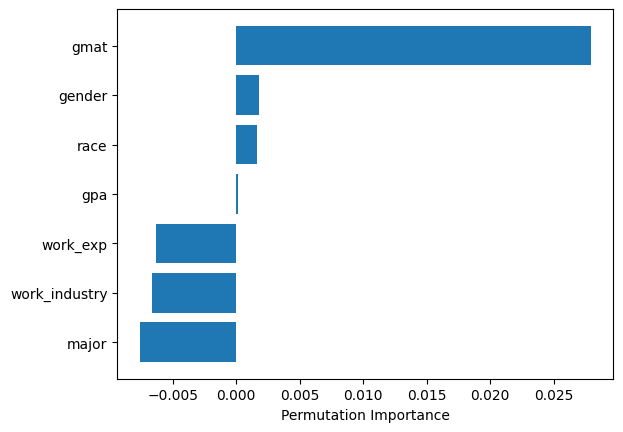

In [62]:
perm_importance = permutation_importance(gbc, X_test, y_test, random_state=42)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X_test.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.show()

#### **Explainability: SHAP**

It is based on cooperative game theory, where each player is given a value/payout that represents their contribution to the game's outcome. This was adapted to how features contribute to a model's outcome. Note that SHAP attempts to explain a model's predictions, not the data itself.

Here, we can use **SHAP (SHapley Additive exPlanations)** to further explain the output of our tree-based model. the computation of SHAP values for a given model is, in general, too complex, and may need to be approximated. However, for a tree-based model, that computation can be adapted to be more efficient, allowing the calculation of exact SHAP values.

The documentation for the library used can be found [here](https://shap.readthedocs.io/en/latest/).

#### **Shapley Values**
The "payout function" represents the contribution of a feature (or a set of features) to the model's prediction. Effectively, it represents the difference between the given prediction and the average/expected prediction (baseline). This payout is distributed fairly among the model's features. To get the Shapley value of a complete instance, the values of each feature are added together (hence the name additive explanations).

A few examples are given below to show how these values work:
- A value of 0 implies the feature had no impact on the prediction for the instance, relative to the baseline.
- A negative or positive Shapley value reflects the feature's contribution to the deviation from the baseline. A positive value makes it more likely that the instance is accepted, and a negative value makes it more likely to be rejected.

In summary, Shapley values provide a way to attribute the prediction of the model to each feature such that the sum of all feature contributions equals the difference between the prediction f(x) and a baseline value (e.g., the average model output across all data points). It can be seen as a measure of the importance of a feature in predicting the target.

In [63]:
shap_explainer = shap.TreeExplainer(gbc)
shap_values = shap_explainer.shap_values(X)

#### Visualize a **single prediction**

In [64]:
instance_index = 0
instance_shap_values = shap_values[instance_index, :]
instance = X_display.iloc[instance_index, :]
print(f"Shapley values:")
print(instance_shap_values)

instance

Shapley values:
[ 1.01018284 -0.12624335  0.07453223 -0.01807528 -1.95177694 -0.89718328
  0.11446222]


gender                       Female
gpa                             3.3
major                      Business
race                          Asian
gmat                          620.0
work_exp                        3.0
work_industry    Financial Services
Name: 0, dtype: object


This plot explains the prediction given for a specific individual, showcasing each feature's contribution. The instance explained here is the one presented in the previous cell.

The red bars indicate that the feature leads to an increase in the overall Shapley value, while the blue bars indicate that the feature leads to a decrease. The length of the bars represents the magnitude of the feature's impact on the prediction.

In [65]:
shap.force_plot(shap_explainer.expected_value, instance_shap_values, instance)

The previous plot represents the same information as the following waterfall plot, but in a more compact manner. It is also harder to understand.

A **Waterfall plot** is likely more adequate to explain a single prediction.

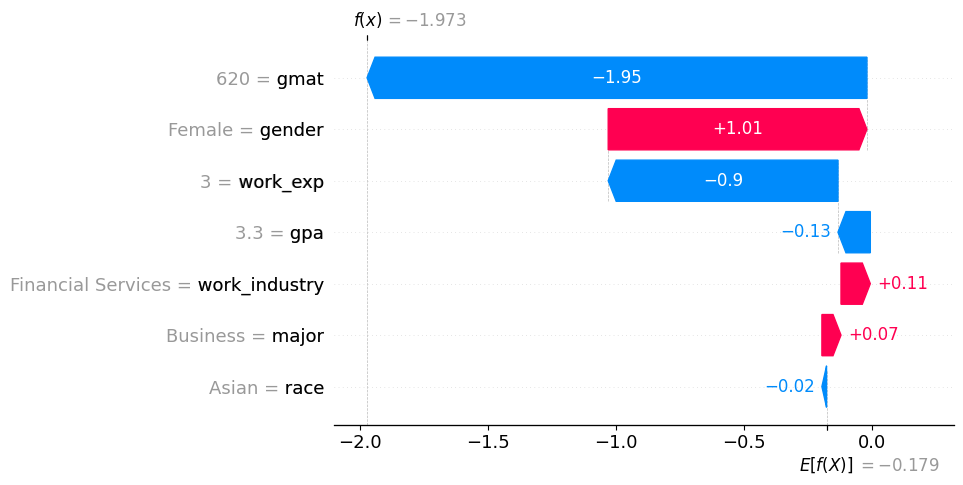

In [66]:
shap.waterfall_plot(
    shap.Explanation(values=instance_shap_values,
                     base_values=shap_explainer.expected_value,
                     data=instance.values,
                     feature_names=X_display.columns)
)

#### Visualize **many predictions**


By visualizing many predictions, we can try to understand as a whole why the model is making the predictions it does. By sampling the predictions in order of different features, we can improve our understanding of the model's predictions.

For example, by sampling the predictions using the GMAT score, we can observe that the model "dislikes" low GMAT scores so it "pushes" those predictions lower and that it likes high GMAT scores so it "pushes" those predictions higher.


Note that, here, red and blue mean similar things as in the single prediction visualization.

The given plot can only handle up to 1000 instances, and the bar at the top just represents the number of each instance.

In [67]:
# This plot can only handle up to about 1000 instances
shap.force_plot(shap_explainer.expected_value, shap_values[:1000, :], X_display.iloc[:1000, :])

#### **Global explanations**
The `summary_plot` is similar to the feature importances presented at the beginning, but has more expressiveness.

- A **non-important feature**, i.e., a feature that does not contribute considerably to the predictions, will have **low absolute Shapley values** and be focused at the center of the plot.
- An **important feature** to predict the outcome has **higher absolute Shapley values**. The feature's values may also be consistent or not. For example, a high GMAT score is associated with a higher probability of admission, while lower scores have less probability, as highlighted by the Shapley values being positive and negative, respectively.

For categorical variables, it may be harder to understand their feature values, since they need to be encoded into integers. In this type of variables, different colors in the plot represent different categories.

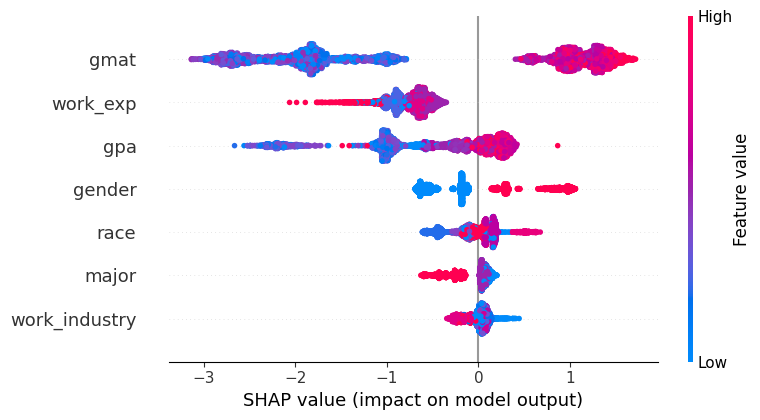

In [68]:
shap.summary_plot(shap_values, X)

#### **SHAP Dependence Plots**
Dependence plots can be used to visualize the relationship between the features, as well as the target.

Since we omit the secondary feature when generating the plot (color bar at the right of the plot), SHAP will automatically select the one that has the strongest interaction with the feature to plot, the one on the x-axis.

We need to beware when interpreting these plots. The color bar at the right does not represent the y-axis. This axis always represents the Shapley values. This is what makes these plots harder to understand, at the tradeoff for more portrayed information.

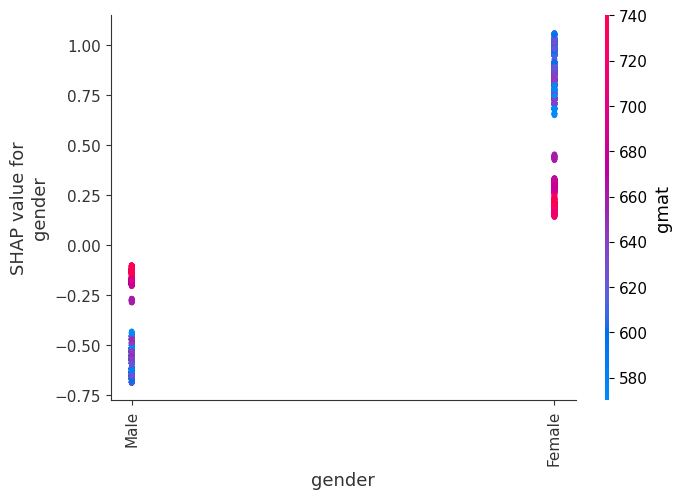

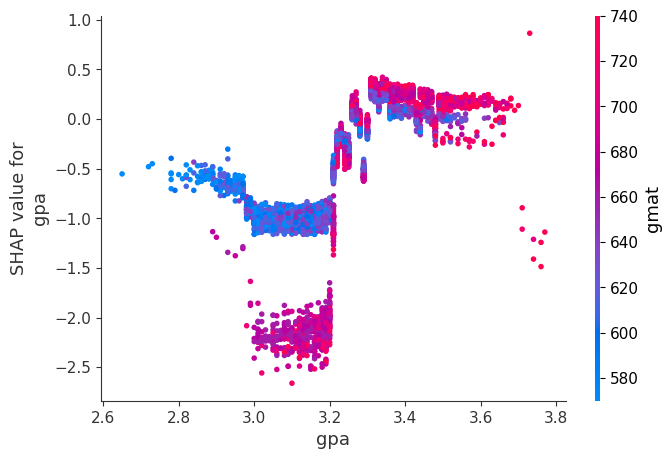

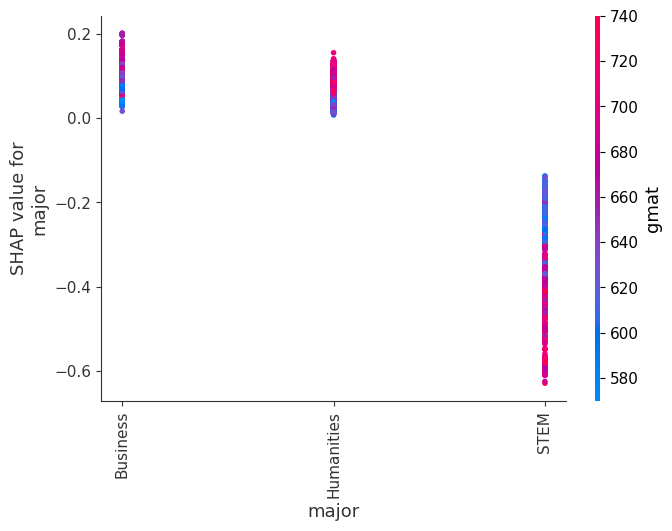

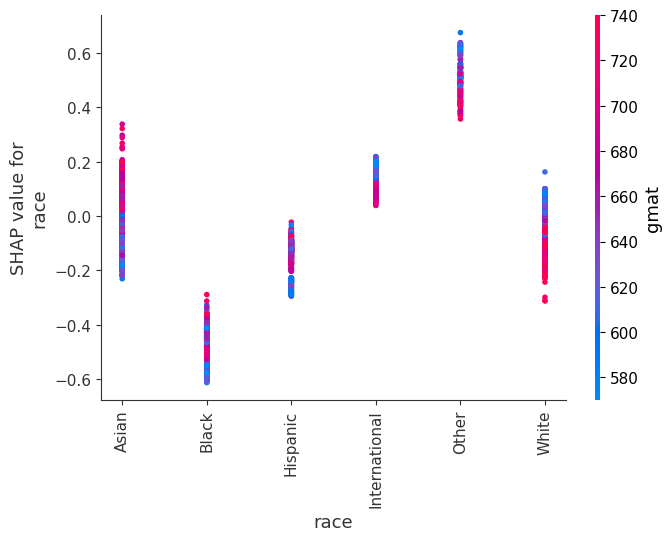

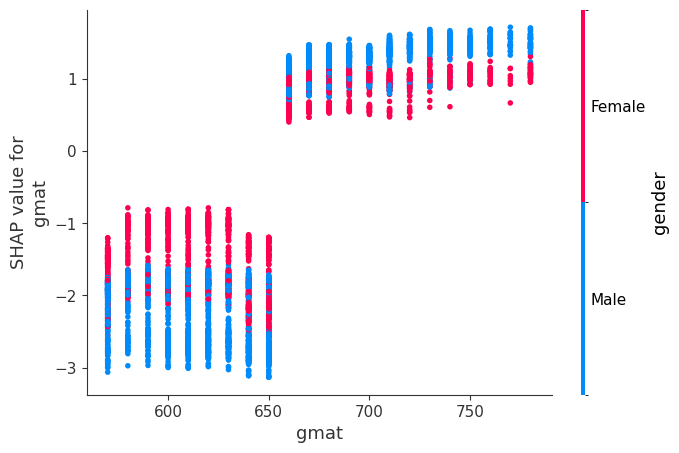

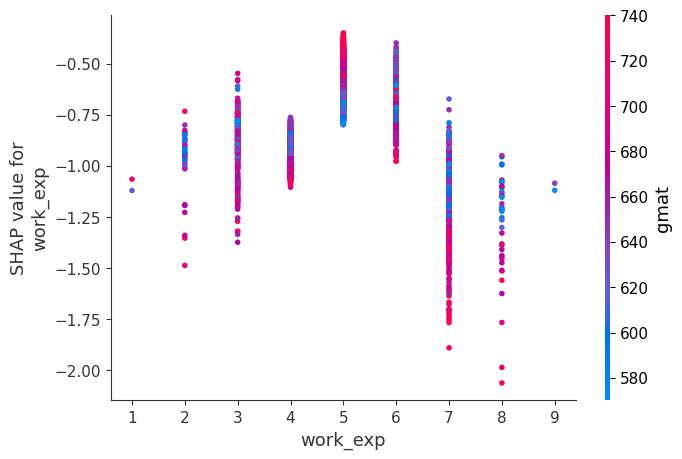

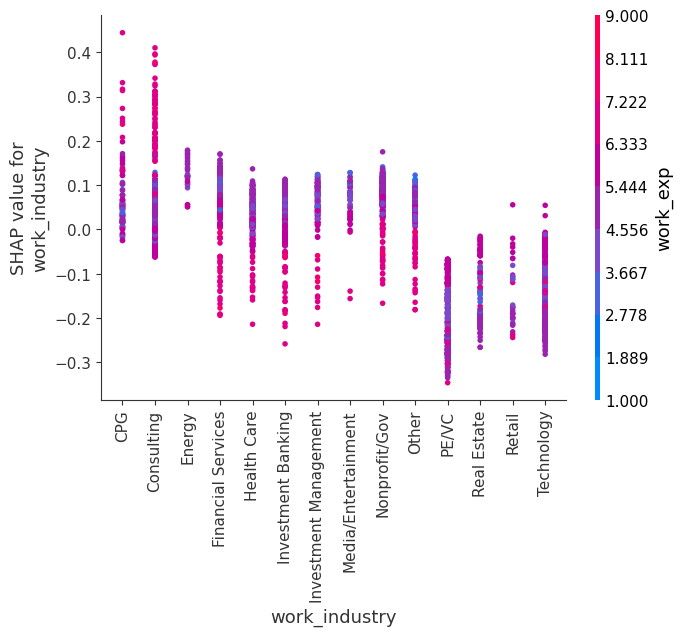

In [69]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values, X, display_features=X_display)

#### Explainability: **LIME**
**Local Interpretable Model-Agnostic Explanations (LIME)** explains local behavior, meaning that it focuses solely on why the model made a specific prediction for a given data point. It does this by approximating the complex model with a simpler, interpretable model (like linear regression) in the vicinity of the instance being explained.

LIME identifies the most important features that influenced the prediction for a specific instance. It answers:

- Which features had the strongest positive or negative impact on the prediction?
- How would small changes to these features alter the prediction?

It can highlight if sensitive features (like gender or ethnicity) have an undue influence on individual predictions. By analyzing multiple explanations, we can assess whether a model exhibits potential bias.

However, LIME allows selecting which features should be used for the surrogate model (the one used to approximate the main model). This could be used to hide potential biases of the original model.

The results from LIME can also somewhat vary depending on the neighbourhood defined for the proximity of the sample to explain (`kernel` and `kernel_width`). These values are left as default in the following cells.

In [70]:
from lime.lime_tabular import LimeTabularExplainer

class_names = ["Not accepted", "Accepted"]

# Select the features used (in this case all of them)
feature_names = list(X.columns)

# Fit the Explainer on the training data set using the LimeTabularExplainer
lime_explainer = LimeTabularExplainer(
    X_train.values,
    feature_names=feature_names,
    class_names=class_names,
    mode="classification",
    # kernel, kernel_width
)

In [71]:
test_instance_index = 0
instance_index = X_test.index[test_instance_index]

instance_display = X_display.iloc[[instance_index]]
instance = X_test.iloc[[test_instance_index]]

instance_display

,gender,gpa,major,race,gmat,work_exp,work_industry
4370,Male,3.48,Humanities,White,630.0,5.0,Nonprofit/Gov


In [72]:
print(f"Model prediction: {gbc.predict(instance)}")
print(f"Prediction probabilities: {gbc.predict_proba(instance)}")

Model prediction: [0]
Prediction probabilities: [[0.98270129 0.01729871]]


c:\Users\jmigu\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


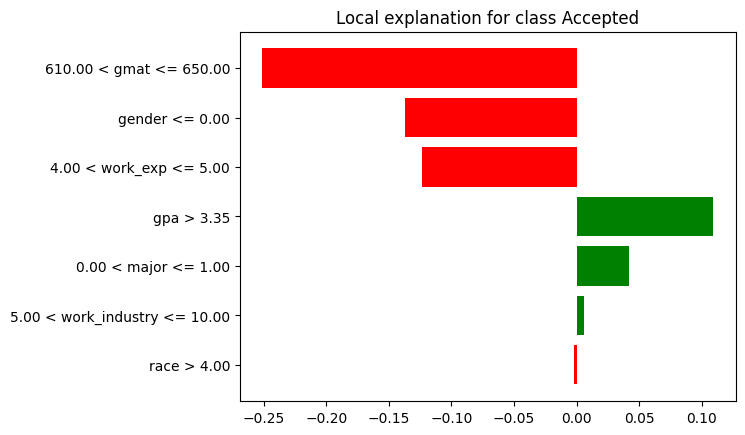

In [73]:
# Generate LIME explanation for the selected instance
explanation = lime_explainer.explain_instance(
    data_row=instance.iloc[0],
    predict_fn=gbc.predict_proba
)
explanation.show_in_notebook()      # Display explanation
fig = explanation.as_pyplot_figure()

## Comparison with SHAP results
The following waterfall plot shows the Shapley values for the same instance as the above plot, allowing a direct comparison with LIME.

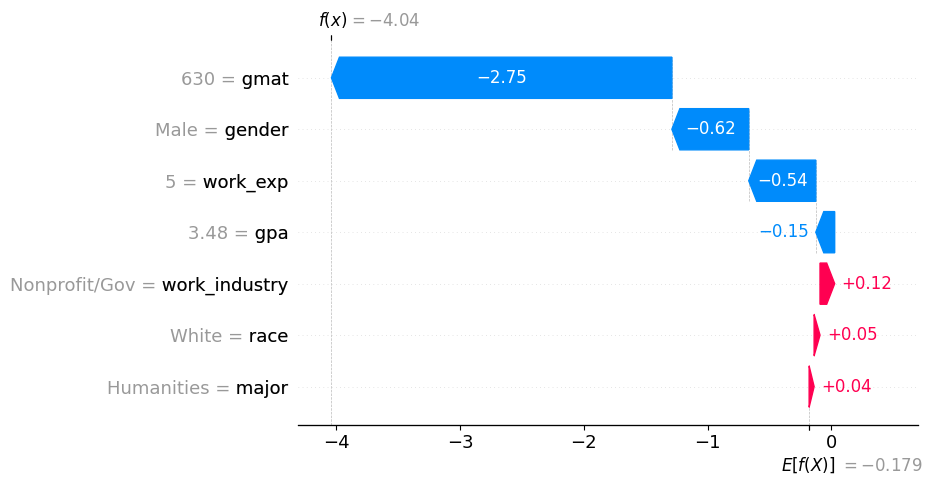

In [74]:
instance_index = int(instance.index[0])
instance_display = instance_display.iloc[0]
instance_shap_values = shap_values[instance_index, :]


shap.waterfall_plot(
    shap.Explanation(values=instance_shap_values,
                     base_values=shap_explainer.expected_value,
                     data=instance_display.values,
                     feature_names=X_display.columns)
)

### **Counterfactual Fairness**

Counterfactual fairness ensures that a model's decisions are fair by asking: would the outcome change if a person's sensitive attribute (e.g., race, gender) were different? It uses causal reasoning to evaluate fairness, considering the relationships between sensitive attributes and other factors. A decision is fair if it remains unchanged in a hypothetical scenario where only the sensitive attribute is altered. This approach helps identify and address biases in complex systems by focusing on the root causes of unfairness.

To demonstrate counterfactual fairness, we will change some features of a specific instance and observe how the model's prediction changes. By altering the features related to the applicant (e.g., race, gender) and observing the impact on the model's prediction, we can evaluate the model's fairness and identify any biases that may exist.

---

#### **Changing the Race from Black to White**

In this step, we modify the `race` feature for all instances that were not admitted, changing it from `Black` to `White`. We then predict the admission status for these updated instances and analyze how the model's predictions change. This approach helps us assess whether the model's decisions are influenced by the applicant's race.

#### **Insights**

After making this adjustment, we observe that the model's predictions were notably affected: the decision shifted from `Deny` to `Admit` for **`14`** out of **`36`** instances initially denied admission. This corresponds to a **`38.89%`** change in predictions, indicating that the applicant's race significantly influences the model's decisions.


In [75]:
df_wrong = df.copy()
df_wrong['pred'] = gbc.predict(X)
df_wrong = df_wrong[df_wrong['admission'] != df_wrong['pred']]

df_FN_black = df_wrong[(df_wrong['pred']==0) & (df_wrong['race'] ==1)]

X_black = df_FN_black.drop(['admission', 'pred'], axis=1)
X_black.race = 5 

y_black_pred = gbc.predict(X_black)
df_FN_black['pred_if_white'] = y_black_pred

print("Wronged admitted black students that the model would admit if they were white:", y_black_pred.sum(), "(", round(y_black_pred.sum()/len(y_black_pred)*100,2), "%)")

Wronged admitted black students that the model would admit if they were white: 14 ( 38.89 %)


C:\Users\jmigu\AppData\Local\Temp\ipykernel_12988\1224412804.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_FN_black['pred_if_white'] = y_black_pred


In the next cell, we can see the instances that were initially denied admission but were predicted to be admitted after changing the applicant's race from `Black` to `White`.

In [76]:
df_FN_black

,gender,gpa,major,race,gmat,work_exp,work_industry,admission,pred,pred_if_white
95,0,3.32,0,1,670.0,4.0,1,1,0,1
167,0,3.36,2,1,700.0,5.0,10,1,0,0
354,0,3.28,2,1,720.0,5.0,10,1,0,0
603,1,3.31,2,1,720.0,7.0,13,1,0,0
614,1,3.22,1,1,660.0,5.0,13,1,0,1
781,0,3.49,2,1,690.0,6.0,5,1,0,0
828,0,3.58,2,1,740.0,4.0,4,1,0,0
1032,0,3.32,2,1,700.0,5.0,13,1,0,0
1167,0,3.47,2,1,700.0,5.0,8,1,0,1
1376,0,3.58,2,1,660.0,5.0,13,1,0,0


#### **Changing the Race from White to Black**

In the next step, we will modify the `race` feature for all admitted instances, changing it from `White` to `Black`. We will then predict the admission status for these modified instances and analyze how the model's predictions are affected. This process helps us evaluate whether the model's decisions are influenced by the applicant's race.

#### **Insights**

After making this change, we observe that the model's predictions were significantly affected: the outcome shifted from `Admit` to `Deny` for **`54`** out of **`165`** initially admitted instances. This represents a **`32.73%`** change in predictions, highlighting that the applicant's race has a considerable influence on the model's decisions.


In [77]:
df_right = df.copy()
df_right['pred'] = gbc.predict(X)
df_right = df_right[df_right['admission'] == df_right['pred']]

df_TP_white = df_right[(df_right['pred']==1)&(df_right['race']==5)]

X_white = df_TP_white.drop(['admission', 'pred'], axis=1)
X_white.race = 1 # switch race to black

y_white_pred = gbc.predict(X_white)
df_TP_white['pred_if_black'] = y_white_pred
print("Correctly admitted white students that the model would not admit if they were black:", (len(df_TP_white)-y_white_pred.sum()), "(", round((len(df_TP_white)-y_white_pred.sum())/len(df_TP_white)*100,2), "%)")

Correctly admitted white students that the model would not admit if they were black: 54 ( 32.73 %)


C:\Users\jmigu\AppData\Local\Temp\ipykernel_12988\3846923879.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_TP_white['pred_if_black'] = y_white_pred


In the next cell, we can see the instances that were initially admitted but were predicted to be denied after changing the applicant's race from `White` to `Black`.

In [78]:
df_TP_white

,gender,gpa,major,race,gmat,work_exp,work_industry,admission,pred,pred_if_black
20,0,3.46,0,5,760.0,5.0,5,1,1,1
24,1,3.47,2,5,710.0,5.0,1,1,1,0
33,1,3.53,2,5,710.0,5.0,1,1,1,0
60,1,3.27,0,5,670.0,5.0,1,1,1,1
64,1,3.39,1,5,680.0,5.0,5,1,1,1
...,...,...,...,...,...,...,...,...,...,...
5883,1,3.24,2,5,680.0,5.0,1,1,1,0
5909,0,3.66,0,5,770.0,5.0,9,1,1,1
5992,1,3.44,2,5,720.0,5.0,8,1,1,0
6050,0,3.42,1,5,670.0,5.0,5,1,1,1


#### **Changing the Gender of Asian Women to Men**

In this step, we modify the `gender` feature for all instances where the applicant is an `Asian Woman`, changing it to `Asian Man`. We then predict the admission status for these updated instances and analyze how the model's predictions are affected. This helps us determine whether the model's decisions are influenced by the applicant's `gender`.

#### **Insights**

After making this modification, we observe that the model's predictions were impacted: the decision changed from `Admit` to `Deny` for **`2`** out of **`30`** instances that were initially admitted. This represents a **`6.67%`** change in predictions, suggesting that the applicant's gender has a measurable influence on the model's decisions.


In [79]:
df_asian_women = df_wrong[(df_wrong['pred']==0) & (df_wrong['gender'] == 1) & (df_wrong['race'] == 0)]

X_asian_women = df_asian_women.drop(['admission', 'pred'], axis=1)
X_asian_women.gender = 0

y_aw_pred = gbc.predict(X_asian_women)
df_asian_women['pred_if_men'] = y_aw_pred
print("Wronged admitted asian women that the model would admit if they were men:", y_aw_pred.sum(), "(", round(y_aw_pred.sum()/len(y_aw_pred)*100,2), "%)")

Wronged admitted asian women that the model would admit if they were men: 2 ( 6.67 %)


C:\Users\jmigu\AppData\Local\Temp\ipykernel_12988\736489957.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_asian_women['pred_if_men'] = y_aw_pred


In the next cell, we can see the instances that were initially admitted but were predicted to be denied after changing the Asian applicant's gender from `Woman` to `Man`.

In [80]:
df_asian_women

,gender,gpa,major,race,gmat,work_exp,work_industry,admission,pred,pred_if_men
0,1,3.30,0,0,620.0,3.0,3,1,0,0
39,1,3.45,1,0,640.0,3.0,10,1,0,0
53,1,3.23,2,0,700.0,6.0,10,1,0,0
79,1,3.10,2,0,680.0,4.0,4,1,0,0
113,1,3.20,1,0,680.0,7.0,1,1,0,0
114,1,3.23,2,0,610.0,5.0,8,1,0,0
138,1,3.31,2,0,600.0,5.0,5,1,0,0
157,1,3.18,2,0,650.0,6.0,8,1,0,0
217,1,3.02,1,0,570.0,4.0,1,1,0,0
223,1,3.19,0,0,630.0,5.0,5,1,0,0
